# Ron Monte Carlo

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import pytz

frequency = "1d"
start_time = (datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=720)).strftime('%Y-%m-%d')
end_time = (datetime.now(pytz.timezone('US/Pacific'))).strftime('%Y-%m-%d')

tickers = ["BTC-CAD"]

# Retrieve and concatenate historical data in one step
df = pd.concat(
    [yf.download(ticker, start=start_time, end=end_time, interval=frequency)[['High', 'Low']].add_prefix(f"{ticker}_") for ticker in tickers],
    axis=1
)

[*********************100%%**********************]  1 of 1 completed


In [2]:
# Add an assertion to ensure there are no NA values in the DataFrame
assert df.isnull().sum().sum() == 0, "DataFrame contains NA values"

df

,BTC-CAD_High,BTC-CAD_Low
Date,,
2022-03-24,55361.382812,53687.386719
2022-03-25,56350.390625,54836.527344
2022-03-26,55864.074219,55099.636719
2022-03-27,58470.886719,55704.371094
2022-03-28,60266.992188,58277.546875
...,...,...
2024-03-08,91648.546875,88748.687500
2024-03-09,94348.257812,89181.023438
2024-03-10,92897.476562,92058.867188


In [3]:
import pandas as pd
import numpy as np
import torch
import os

from gluonts.dataset.common import ListDataset
from gluonts.torch.model.tft import TemporalFusionTransformerEstimator
from gluonts.transform.feature import MissingValueImputation

torch.set_float32_matmul_precision('high')
                                   
# Assuming df is your DataFrame with the data
target_column_low = 'BTC-CAD_Low' 

# Ensure the DataFrame's index is a datetime index and set the frequency explicitly if needed
df.index = pd.to_datetime(df.index)
freq = "D"  # Set the frequency of your data, e.g., 'D' for daily. Adjust as needed.
df = df.asfreq(freq)

# Define the prediction length
prediction_length = 1  # Set your prediction length
context_length = 60
volatility_window = 60

model_low = 'ron_low_huge.pth'

predictor_low = torch.load(model_low)

In [4]:
%%time


# Modify perform_rolling_prediction to handle timezone-aware datetimes
def perform_rolling_prediction(df, predictor, target_column, context_length, prediction_length, target_date, noise_mean, noise_std_dev, volatility_window=60):
    rolling_predictions = []
    prediction_dates = []

    temp_df = df.copy()

    if not temp_df.index.tz:
        temp_df.index = temp_df.index.tz_localize(pytz.timezone('US/Pacific'))

    current_max_date = temp_df.index.max()

    if (target_date - current_max_date).days < 0:
        return "Target date is before the current latest date in the dataset."

    start_prediction_date = current_max_date + pd.Timedelta(1, unit='D')
    prediction_dates = pd.date_range(start=start_prediction_date, end=target_date, freq='D', tz=pytz.timezone('US/Pacific'))
    
    for i, prediction_date in enumerate(prediction_dates):
        end_idx = len(temp_df) - prediction_length + i
        test_data = ListDataset([{"start": temp_df.index[0], "target": temp_df[target_column][:end_idx].values}], freq='D')

        forecast = next(predictor.predict(test_data))
        predicted_value = forecast.quantile(0.5)[-1]
        
        # Calculate dynamic noise based on recent market volatility
        recent_volatility = temp_df[target_column][-volatility_window:].pct_change().std()
        noise = np.random.laplace(noise_mean, recent_volatility / np.sqrt(2))

        predicted_value_with_noise = predicted_value + noise
        rolling_predictions.append(predicted_value_with_noise)

        new_row = pd.DataFrame({target_column: [predicted_value_with_noise]}, index=[prediction_date])
        temp_df = pd.concat([temp_df, new_row])

    return prediction_dates, rolling_predictions


######## Monte-Carlo Simulation Function
def monte_carlo_simulation_for_date(df, predictor_low, target_column_low, context_length, prediction_length, target_date, noise_mean_low, noise_std_dev_low, num_simulations=10):
    low_simulations = []
    for _ in range(num_simulations):
        # Generate rolling predictions for low with noise
        _, rolling_predictions_low = perform_rolling_prediction(df, predictor_low, target_column_low, context_length, prediction_length, target_date, noise_mean_low, noise_std_dev_low, volatility_window)

        low_prediction = rolling_predictions_low[-1]

        simulated_low_return = np.random.laplace(mean_low, std_dev_low)

        simulated_low_price = low_prediction * (1 + simulated_low_return)

        low_simulations.append(simulated_low_price)

    # Calculate confidence intervals
    low_lower_bound = np.percentile(low_simulations, 2.5)
    low_upper_bound = np.percentile(low_simulations, 97.5)

    return np.mean(low_simulations), low_lower_bound, low_upper_bound


# Function to perform Monte Carlo simulation for each date up to target date
def monte_carlo_simulation_for_range(df, predictor_low, target_column_low, context_length, prediction_length, current_date, target_date, noise_mean_low, noise_std_dev_low, num_simulations=10):
    simulation_results = []
    for single_date in pd.date_range(start=current_date, end=target_date, freq='D'):
        mean, lower_ci, upper_ci = monte_carlo_simulation_for_date(
            df, predictor_low, target_column_low, context_length, prediction_length, single_date, noise_mean_low, noise_std_dev_low, num_simulations
        )
        simulation_results.append({'Date': single_date, 'Mean': mean, '95% CI Low': lower_ci, '95% CI High': upper_ci})
    
    return pd.DataFrame(simulation_results)




################## DATE #################
(current_date) = datetime.now(pytz.timezone('US/Pacific'))
target_date = pd.Timestamp('2024-06-21-13:30').tz_localize(pytz.timezone('US/Pacific'))
################## DATE #################




# Formatting dates for better readability
formatted_current_date = current_date.strftime('%Y-%m-%d %H:%M:%S %Z')
formatted_target_date = target_date.strftime('%Y-%m-%d %H:%M:%S %Z')

# Improved print statement
print(f"Current Date and Time (US/Pacific): {formatted_current_date}")
print(f"Target Date and Time (US/Pacific): {formatted_target_date}")

# Calculate daily returns for High and Low
df['BTC-CAD_Low_Return'] = df['BTC-CAD_Low'].pct_change()

# Calculate the mean and standard deviation of daily returns
mean_low = df['BTC-CAD_Low_Return'].mean()
std_dev_low = df['BTC-CAD_Low_Return'].std()

# Ensure both dates are either timezone-aware or timezone-naive
current_date_naive = current_date.replace(tzinfo=None)  # Convert to naive datetime
target_date_naive = target_date.tz_localize(None)  # Convert to naive Timestamp if it's timezone-aware

# Calculate the period from current date to target date
period_to_target = (target_date_naive - current_date_naive).days

# Perform Monte Carlo simulation for the target date using both high and low predictors
num_simulations = 50

# Perform Monte Carlo simulation for each date up to the target date
simulation_df = monte_carlo_simulation_for_range(
    df, predictor_low, target_column_low, context_length, prediction_length, current_date, target_date, mean_low, std_dev_low, num_simulations=num_simulations
)

Current Date and Time (US/Pacific): 2024-03-13 18:42:19 PDT
Target Date and Time (US/Pacific): 2024-06-21 13:30:00 PDT
CPU times: total: 48min 45s
Wall time: 49min 20s


In [5]:
simulation_df.set_index('Date', inplace=True)

In [6]:
min_share_price = simulation_df['95% CI Low'].min() / 6989
min_share_price

12.355963903853223

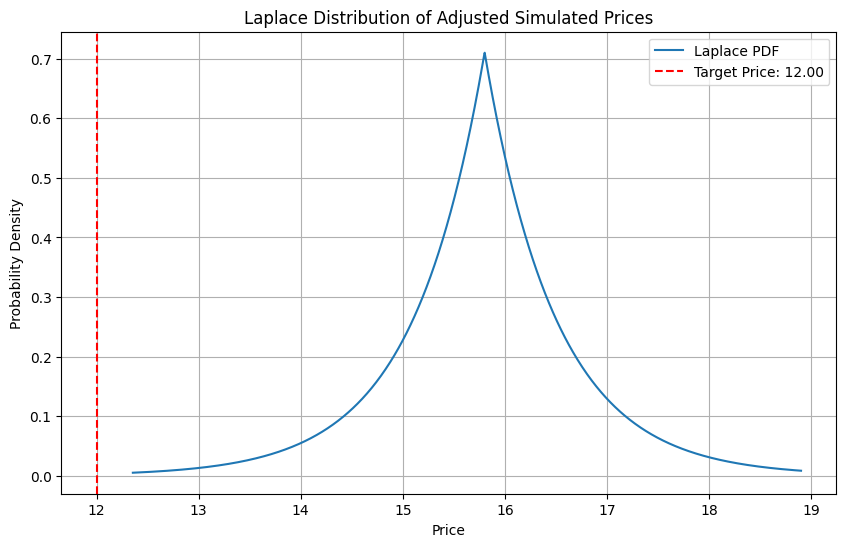

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

btcc_div = 6989
target_price = 12 # Adjusted target price

# Extract and adjust the mean simulated prices
sim_mean = simulation_df['Mean'] / btcc_div
sim_low = simulation_df['95% CI Low'] / btcc_div
sim_high = simulation_df['95% CI High'] / btcc_div

# Calculate parameters for the Laplace distribution
laplace_mean = np.mean(sim_mean)  # Mean of the adjusted prices
laplace_b = np.std(sim_mean) / np.sqrt(2)  # Adjusted scale parameter

# Calculate the probability density at the adjusted target price
probability_density = stats.laplace.pdf(target_price, loc=laplace_mean, scale=laplace_b)

# Plotting the probability distribution
x = np.linspace(min(sim_low), max(sim_high), 1000)
pdf = stats.laplace.pdf(x, loc=laplace_mean, scale=laplace_b)

plt.figure(figsize=(10, 6))
plt.plot(x, pdf, label='Laplace PDF')
plt.axvline(x=target_price, color='r', linestyle='--', label=f'Target Price: {target_price:.2f}')
plt.title('Laplace Distribution of Adjusted Simulated Prices')
plt.xlabel('Price')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.show()